In [56]:
%matplotlib inline 
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
import skvideo.io
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import cv2 as cv


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras import optimizers

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, BaggingRegressor)
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
#Support function from the given repo for the project
def get_videos_from_folder(data_folder):
    '''
    get a list of video x wehre each video is a numpy array in the format [n_frames,width,height] 
    with uint8 elements.
    argument: relative path to the data_folder from the source folder.
    '''
    data_folder = os.path.join(dir_path,data_folder)
    x = []
    file_names = []
    
    if os.path.isdir(data_folder):
        for dirpath, dirnames, filenames in os.walk(data_folder):
            filenames = natsort.natsorted(filenames,reverse=False)
            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                statinfo = os.stat(file_path)
                if statinfo.st_size != 0:
                    video = skvideo.io.vread(file_path, outputdict={"-pix_fmt": "gray"})[:, :, :, 0]
                    x.append(video)
                    file_names.append(int(filename.split(".")[0]))

    indices = sorted(range(len(file_names)), key=file_names.__getitem__)
    x = np.take(x,indices)
    return x

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of video. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y


def save_solution(csv_file,prob_positive_class):
    with open(csv_file, 'w') as csv:
        df = pd.DataFrame.from_dict({'id':range(len(prob_positive_class)),'y': prob_positive_class})
        df.to_csv(csv,index = False)
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def save_tf_record(x,file_name,y = None):
    writer = tf.python_io.TFRecordWriter(file_name)
    if y is None:
        for video in x:
            sys.stdout.flush()
            feature = {'len': _int64_feature(video.shape[0]),
                       'height': _int64_feature(video.shape[1]),
                       'width': _int64_feature(video.shape[2]),
                       'video': _bytes_feature(tf.compat.as_bytes(video.tostring()))}
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
    else:
        for video,label in zip(x,y):
            sys.stdout.flush()
            feature = {'len': _int64_feature(video.shape[0]),
                       'height': _int64_feature(video.shape[1]),
                       'width': _int64_feature(video.shape[2]),
                       'video': _bytes_feature(tf.compat.as_bytes(video.tostring())),
                       'label': _int64_feature(label)}
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

def prob_positive_class_from_prediction(pred):
    return np.array([p['probabilities'][1] for p in pred])

def decode(serialized_example):
    features = tf.parse_single_example(
        serialized_example,
        features={
            'len': tf.FixedLenFeature([], tf.int64),
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'label': tf.FixedLenFeature([], tf.int64,default_value = 0),
            'video': tf.FixedLenFeature([], tf.string),
        })
    video = tf.decode_raw(features['video'], tf.uint8)
    height = features['height']
    width = features['width']
    length = features['len']
    shape = tf.stack([length,height,width])
    video = tf.reshape(video,shape)
    label = features['label']
    features = {'video':video}
    return features,label

def input_fn_from_dataset(files,batch_size = 1,num_epochs = None,shuffle = True):
    data_set = tf.data.TFRecordDataset(files)
    if shuffle:
        data_set = data_set.shuffle(buffer_size=len(files)) 
    data_set = data_set.map(decode)
    data_set = data_set.padded_batch(batch_size,padded_shapes= ({'video':[212,100,100]},[]))
    data_set = data_set.repeat(num_epochs)
    data_set = data_set.prefetch(batch_size)
    
    return data_set

def decode_frame(serialized_example):
    features = tf.parse_single_example(
        serialized_example,
        features={
            'len': tf.FixedLenFeature([], tf.int64),
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'label': tf.FixedLenFeature([], tf.int64,default_value = 0),
            'video': tf.FixedLenFeature([], tf.string),
        })
    video = tf.decode_raw(features['video'], tf.uint8)
    height = features['height']
    width = features['width']
    length = features['len']
    shape = tf.stack([length,height,length])
    video = tf.reshape(video,shape)
    label = features['label']
    label = tf.expand_dims(label,axis=-1)
    label = tf.tile(label,tf.expand_dims(length,axis=-1))
    features = {'frame':video}
    return features,label

def input_fn_frame_from_dataset(files,batch_size = 1,num_epochs = None):
    data_set = tf.data.TFRecordDataset(files)
    data_set = data_set.shuffle(buffer_size=len(files)) 
    data_set = data_set.map(decode_frame)
    data_set = data_set.shuffle(buffer_size=batch_size)
    data_set = data_set.apply(tf.contrib.data.unbatch())
    data_set = data_set.batch(batch_size)
    data_set = data_set.repeat(num_epochs)
    data_set = data_set.prefetch(batch_size)
    
    return data_set
#Custom support functions

#Count for the minimum number of frames video among the list_array of videos
def count_min_number_frames(list_array):
    min_frames = 999
    for sample in list_array:
        if sample.shape[0] < min_frames:
            min_frames = sample.shape[0]
            
    return min_frames

#Count number of subsamples given the min_frames
def count_new_subsamples(list_array, min_frames, train_set=True, labels=[]):
    """Params:
       - list array: list of videos (list of numpy array)
       - min_frames: number of frames per subsample (equal to the minimum number fo frames among training and test videos)
       - train_set: set to false if the dataset passed is the test set
       - labels: pass the labels for the train set
       Return:
       - n_new_subsamples 
         if train set == true -> int(video frames/min_frames)
         if test set == false -> len(list_array) just pick one subsample of min_frames per video and discard the other frames
    """
    classes = [0,0]
    i = 0
    n_new_samples = 0
    for sample in list_array:
        n_new_samples += int(sample.shape[0]/min_frames)
        if train_set:
            classes[labels[i]] += int(sample.shape[0]/min_frames)
        i+=1
    print("Train set" if train_set==True else "Test set")
    print(n_new_samples)
    print("Labels per class ->",classes if train_set==True else "")
    return n_new_samples



def extract_features(X_videos):
    total_videos = len(X_videos)
    total_features = 13205
    #Extracting features
    X_features = np.zeros((total_videos,total_features))
    video_n = 0
    for video in tqdm(X_videos):
        
        video_grad = np.diff(video,axis = 0) #frame-wise gradient
        height_im_grad = video_grad.shape[1]
        width_im_grad = video_grad.shape[2]

        for idx in range(height_im):

            X_features[video_n][idx*6] = np.mean(video[:,:,idx]) #entire video video mean_column_pixels            1
            X_features[video_n][idx*6+1] = np.mean(video[:,idx,:]) #entire video mean_row_pixels             2
            X_features[video_n][idx*6+2] = np.std(video[:,:,idx]) #entire video std_column_pixels            3
            X_features[video_n][idx*6+3] = np.std(video[:,idx,:]) #entire video std_row_pixels               4
            X_features[video_n][idx*6+4] = np.count_nonzero(video[:,:,idx]) #entire nonzero_column_pixels    5
            X_features[video_n][idx*6+5] = np.count_nonzero(video[:,idx,:]) #entire nonzero_row_pixels       6
        
        # ? TODO ? Taking some of the same previous features but just frame-wise?
        idx_next = height_im*6
      
        X_features[video_n][idx_next+1] = np.mean(video_grad) #mean_video_grad    1
        X_features[video_n][idx_next+2] = np.std(video_grad) #std_video_grad      2
        X_features[video_n][idx_next+3] = np.mean(video_grad) #mean_frame_grad    3
    
        idx_next = idx_next+4

        idx_frame_grad = 0
        
        for frame_grad in video_grad:

            X_features[video_n][idx_next  + 1 +   idx_frame_grad*6*height_im_grad] = np.std(frame_grad) #Std of the gradient of the single frame std_frame_grad      1

            for idx in range(height_im_grad):
                
                #print("Inside inside: ",idx_next  + 1 +   idx*6 + idx_frame_grad*6*height_im_grad)
                X_features[video_n][idx_next  + 1 +   idx*6 + idx_frame_grad*6*height_im_grad] = np.mean(frame_grad[:,idx]) #mean_grad_column_pixels   1
                X_features[video_n][idx_next  + 2 +   idx*6 + idx_frame_grad*6*height_im_grad] = np.mean(frame_grad[idx,:]) #mean_grad_row_pixels           2
                X_features[video_n][idx_next  + 3 +   idx*6 + idx_frame_grad*6*height_im_grad] = np.std(frame_grad[:,idx]) #std_grad_column_pixels          3
                X_features[video_n][idx_next  + 4 +   idx*6 + idx_frame_grad*6*height_im_grad] = np.std(frame_grad[idx,:]) #std_grad_row_pixels               4
                X_features[video_n][idx_next  + 5 +   idx*6 + idx_frame_grad*6*height_im_grad] = np.count_nonzero(frame_grad[:,idx]) #nonzero_grad_column_pixels  5
                X_features[video_n][idx_next  + 6 +   idx*6 + idx_frame_grad*6*height_im_grad] = np.count_nonzero(frame_grad[idx,:]) #nonzero_grad_row_pixels     6
                #print("Finish Inside inside: ",idx_next  + 6 +   idx*6 + idx_frame_grad*6*height_im_grad)
        
            idx_frame_grad+=1
    
        print(video_n)
        video_n+=1
    return X_features

def extract_features_ax(X_videos):
    total_videos = len(X_videos)
    #Extracting features
    
    all_features = list()
    for video in X_videos:
        feature_vec = list()
        
        video_grad = np.diff(video,axis = 0) #frame-wise gradient
        height_im_grad = video_grad.shape[1]
        width_im_grad = video_grad.shape[2]
        
        # compute the sum of pixels per frame
        heartBeatApprox = np.sum(np.sum(video, axis=1), axis=1)
        feature_vec.append(np.min(heartBeatApprox))
        feature_vec.append(np.max(heartBeatApprox))
        feature_vec.append(np.mean(heartBeatApprox))
        feature_vec.append(np.std(heartBeatApprox))
        feature_vec.append(np.std(heartBeatApprox))
        feature_vec += heartBeatApprox.tolist()
        
        
        
        for idx in range(height_im):
            feature_vec.append(np.mean(video[:,:,idx])) #entire video video mean_column_pixels            1
            feature_vec.append(np.mean(video[:,idx,:])) #entire video mean_row_pixels             2
            feature_vec.append(np.std(video[:,:,idx])) #entire video std_column_pixels            3
            feature_vec.append(np.std(video[:,idx,:])) #entire video std_row_pixels               4
            feature_vec.append(np.count_nonzero(video[:,:,idx])) #entire nonzero_column_pixels    5
            feature_vec.append(np.count_nonzero(video[:,idx,:])) #entire nonzero_row_pixels       6
        
        # ? TODO ? Taking some of the same previous features but just frame-wise?
        feature_vec.append(np.mean(video_grad)) #mean_video_grad    1
        feature_vec.append(np.std(video_grad)) #std_video_grad      2
        feature_vec.append(np.mean(video_grad)) #mean_frame_grad    3
    
    
        for frame_grad in video_grad:
            feature_vec.append(np.mean(frame_grad))
            feature_vec.append(np.std(frame_grad)) #Std of the gradient of the single frame std_frame_grad      1

            for idx in range(height_im_grad):            
                feature_vec.append(np.mean(frame_grad[:,idx])) #mean_grad_column_pixels   1
                feature_vec.append(np.mean(frame_grad[idx,:])) #mean_grad_row_pixels           2
                feature_vec.append(np.std(frame_grad[:,idx])) #std_grad_column_pixels          3
                feature_vec.append(np.std(frame_grad[idx,:])) #std_grad_row_pixels               4
                feature_vec.append(np.count_nonzero(frame_grad[:,idx])) #nonzero_grad_column_pixels  5
                feature_vec.append(np.count_nonzero(frame_grad[idx,:])) #nonzero_grad_row_pixels     6
        
        total_features = len(feature_vec)
        all_features.append(feature_vec)
        
    X_features = np.zeros((total_videos,total_features))
    
    for i in range(total_videos):
        X_features[i,:] = all_features[i]
        
    return X_features

def extract_ids(data_folder):
    
    print("Extracting ids from test set videos")
    data_folder = os.path.join(dir_path,data_folder)
    x = []
    file_names = []
    
    if os.path.isdir(data_folder):
        for dirpath, dirnames, filenames in os.walk(data_folder):
            filenames = natsort.natsorted(filenames,reverse=False)
            ids = []
            for filename in filenames:
              ids.append(int(filename.split(".")[0]))
    return ids

def make_submission(filename, predictions):
    ids = extract_ids(test_folder)
    df = pd.DataFrame({'id':ids, 'y':predictions})
    df[["id", "y"]].to_csv("submissions/"+filename, index= False)

In [4]:
seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()

train_folder = os.path.join(dir_path,"data/train/")
test_folder = os.path.join(dir_path,"data/test/")

train_target = os.path.join(dir_path,'data/train_target.csv')

print("Current dir -> ", dir_path)
print("Train folder -> ",train_folder)
print("Train target -> ",train_target)
print("Test folder -> ",test_folder)

#Load data from csv file
print("Train Data\n")
x_train = get_videos_from_folder(train_folder) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels
print("Test Data\n")
x_test = get_videos_from_folder(test_folder) #List of numpy arrays

Current dir ->  /home/ax/master/2018_02/ml/task4
Train folder ->  /home/ax/master/2018_02/ml/task4/data/train/
Train target ->  /home/ax/master/2018_02/ml/task4/data/train_target.csv
Test folder ->  /home/ax/master/2018_02/ml/task4/data/test/
Train Data

Test Data



Class 0


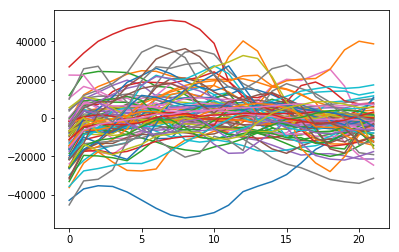

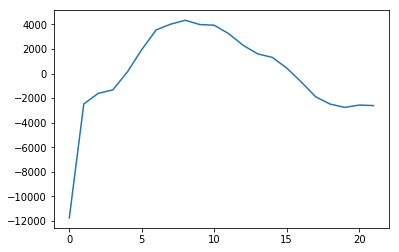

Class 1


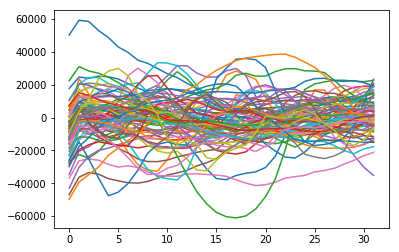

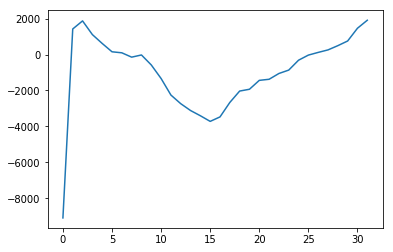

In [73]:
# select the 4 videos from each class
n_test_videos = 100
index_cl_0 = y_train == 0
index_cl_1 = y_train == 1

videos_cl_0 = x_train[index_cl_0][:n_test_videos]
videos_cl_1 = x_train[index_cl_1][:n_test_videos]

heart_beat_0 = []
heart_beat_1 = []

def get_info(videos):    
    min_len = 1000
    heart_beat = []
    for video in videos:
        min_len = min(min_len, video.shape[0])
        signal = np.sum(np.sum(video, axis=1), axis=1)
        heart_beat.append(signal - signal.mean())
        
    heart_beat_cut = [sig[:min_len] for sig in heart_beat]
    
    for y in heart_beat_cut:
        plt.plot(y)
        
    plt.show()
    
    plt.plot(np.array(heart_beat_cut).mean(axis=0))
    plt.show()
    
print("Class 0")
get_info(videos_cl_0)
print("Class 1")
get_info(videos_cl_1)


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in arctan


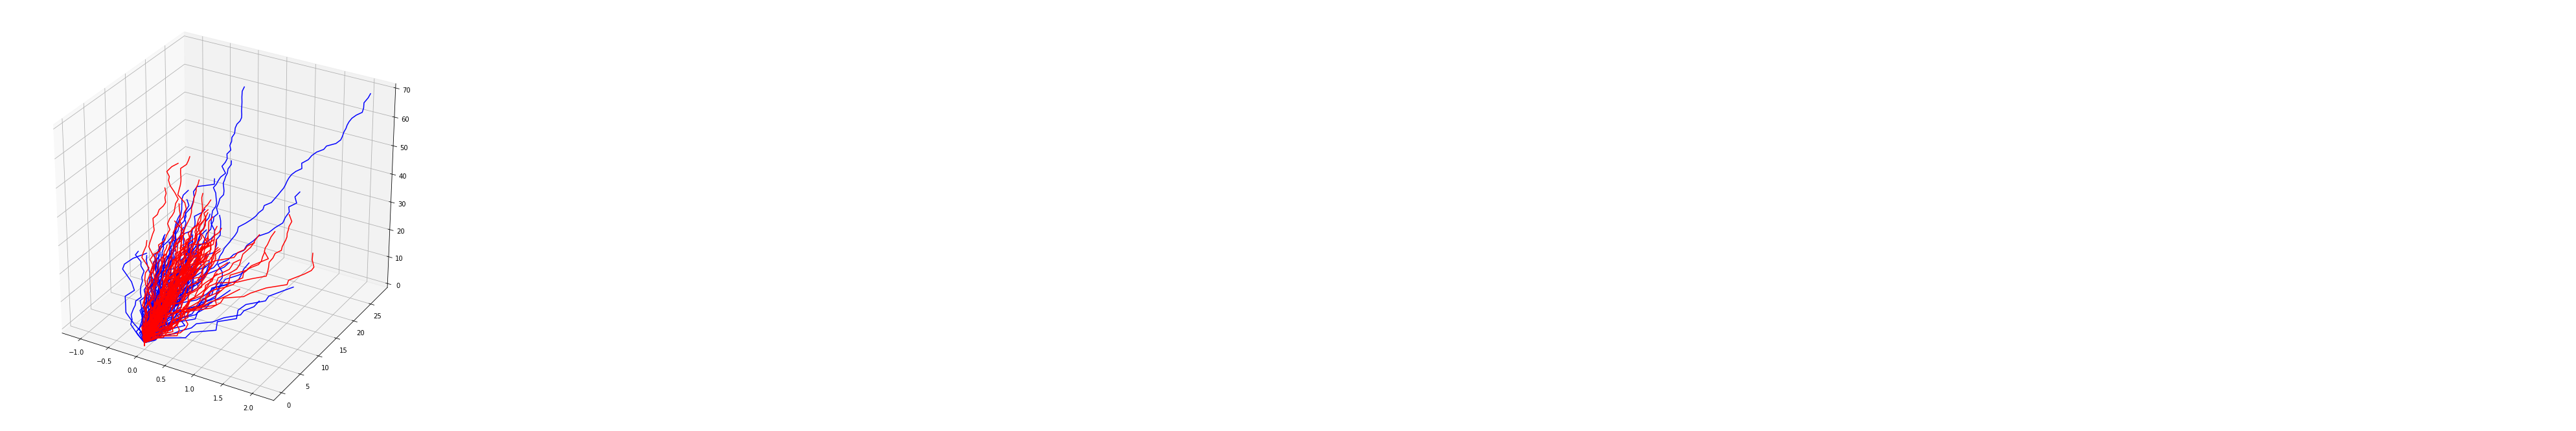

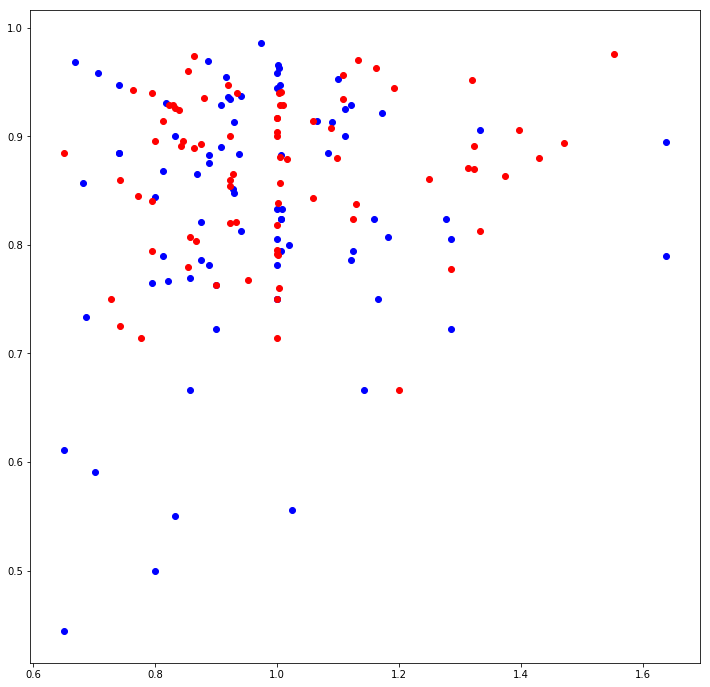

In [76]:
def get_velocity_vec_frames(prev, next):
    flow = cv.calcOpticalFlowFarneback(
        prev.astype(np.uint8), 
        next.astype(np.uint8),
        None,
        0.5,    
        int(3),      
        int(10),      
        int(3),           
        int(5),    
        1.2,         
        0)
    u = flow[...,0]
    v = flow[...,1]
    
    delta_avg = np.sum(np.sqrt(np.square(u) + np.square(v))) / (100 * 100)
    vu_frac = np.divide(v, u)
    # x/0 => inf setting inf to zero and 0/ 0 is nan => set to zero as well
    vu_frac[vu_frac == np.inf] = 0
    vu_frac = np.nan_to_num(vu_frac)
    
    theta_avg = np.sum(np.arctan(vu_frac)) / (100 * 100)
    
    return delta_avg, theta_avg
    
def get_parametric_velocity_curve(avg_velocities):
    curve = list()
    x_prev = 0
    y_prev = 0
    curve.append([x_prev, y_prev])
    
    for (delta, theta) in avg_velocities:
        x_next = x_prev + delta * np.cos(theta)
        y_next = y_prev + delta * np.sin(theta)
        curve.append([x_next, y_next])
        x_prev = x_next
        y_prev = y_next
    return curve
    
def get_avg_velocity_vec(video):
    avg_velocities = []
    N=3
    frame_index = list(range(len(video)))[0::N]
    prev = video[frame_index[0]]
    for i in frame_index:
        next = video[i]
        avg_velocities.append(get_velocity_vec_frames(prev, next))
        prev = next
        
    avg_velocity_curve = get_parametric_velocity_curve(avg_velocities)
    
    return avg_velocity_curve

def get_avg_velocity_from_videos(videos):
    avg_velo = []
    for video in tqdm(videos):
        avg_velo.append(get_avg_velocity_vec(video))
    return avg_velo


def get_feature_from_curve(curve):
    features = []
    N = len(curve)
    
    X = np.array([c[0] for c in curve])
    Y = np.array([c[1] for c in curve])
    M_X = np.mean(X)
    M_Y = np.mean(Y)
    
    X_plus = np.sum(X >= M_X)
    X_minus = np.sum(X <=  M_X)
    
    Y_plus = np.sum(Y >= M_Y)
    Y_minus = np.sum(Y <=  M_Y)
    
    V_avg = 0.5 * ( (X_plus / X_minus) + (Y_plus / Y_minus))
    
    # the first order difference is given by out[n] = a[n+1] - a[n] along the given axis,
    X_diff = np.diff(X)
    Y_diff = np.diff(Y)
    
    delta_max_x = np.max(np.abs(X)) * 0.125 # factor from the paper
    delta_max_y = np.max(np.abs(Y)) * 0.125
    
    F_X = np.sum(X_diff < delta_max_x)
    F_Y = np.sum(Y_diff < delta_max_y)
    
    F_avg =(1.0 / (2.0 * N)) * (F_X + F_Y) 
    
    
    return [V_avg, F_avg]

# COMPUTE the avg velocity for both classes
avg_velocity_0 = get_avg_velocity_from_videos(videos_cl_0)
avg_velocity_1 = get_avg_velocity_from_videos(videos_cl_1)

# compute the features
features_0 = []
for curve in avg_velocity_0:
    features_0.append(get_feature_from_curve(curve))
    
features_1 = []
for curve in avg_velocity_1:
    features_1.append(get_feature_from_curve(curve))

    
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
for i in range(len(avg_velocity_0)):
    zline = range(len(avg_velocity_0[i]))
    yline = [val[0] for val in avg_velocity_0[i]]
    xline = [val[1] for val in avg_velocity_0[i]]
    ax.plot3D(xline, yline, zline, 'blue')
    


# Data for a three-dimensional line
for i in range(len(avg_velocity_1)):
    zline = range(len(avg_velocity_1[i]))
    yline = [val[0] for val in avg_velocity_1[i]]
    xline = [val[1] for val in avg_velocity_1[i]]
    ax.plot3D(xline, yline, zline, 'red')
#hsv = np.zeros((100, 100, 3))
#hsv[...,1] = 255
#hsv[...,0] = ang*180/np.pi/2
#hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
fig = plt.figure(figsize=(12, 12))
for feature in features_0:
    plt.scatter(feature[0], feature[1], c="blue")
    
for feature in features_1:
    plt.scatter(feature[0], feature[1], c="red")



In [4]:
#Compute minimum number of frames per video in train and test set
min_frames_train = count_min_number_frames(x_train)
min_frames_test = count_min_number_frames(x_test)

#Pick minimum number of frames among all dataset
min_frames = min_frames_train if min_frames_train<min_frames_test else min_frames_test
print("Minimum number of frames among video dataset -> ",min_frames)

#Count the number of new subsamples per video of min_frames
n_train_subsamples = count_new_subsamples(x_train, min_frames, train_set = True, labels=y_train)
n_test_subsamples = count_new_subsamples(x_test, min_frames, train_set = False)

Minimum number of frames among video dataset ->  22
Train set
402
Labels per class -> [182, 220]
Test set
183
Labels per class -> 


In [5]:
#Construct new datasets from subsamples

height_im = x_train[0].shape[1]
width_im = x_train[0].shape[2]
X = np.zeros((n_train_subsamples, min_frames, height_im, width_im))
Y = np.zeros((n_train_subsamples))


#TRAIN

sample_idx = 0
subsample_idx = 0

#Train subsamples
for sample_video in x_train:
    
    subsamples = int(sample_video.shape[0]/min_frames)
    
    for i in range(subsamples):
        X[subsample_idx,:,:,:] = sample_video[i*min_frames : i*min_frames+min_frames, :, :]
        Y[subsample_idx] = y_train[sample_idx]
        subsample_idx+=1
        
    sample_idx+=1

    
#TEST
X_test = np.zeros((len(x_test), min_frames, height_im, width_im))


sample_idx = 0
subsample_idx = 0

#Test subsamples
# ? TODO ? create test set subsamples and go for a maximum consensus or other tecniques for prediction?
for sample_video in x_test:
    
    X_test[subsample_idx,:,:,:] = sample_video[0 : min_frames, :, :]
    """    subsamples = int(sample.shape[0]/min_frames)
    
    for i in range(subsamples):
        X[subsample_idx,:,:,:] = sample[i*min_frames : i*min_frames+min_frames, :, :]
        Y[subsample_idx] = y_train[sample_idx]
        subsample_idx+=1"""
    subsample_idx+=1
    #sample_idx+=1

    
#Reshaping for (n_samples, n_frames, height_frame, width_frame )
X = np.reshape(X,(402,22,100,100))
X_test = np.reshape(X_test, (len(x_test), min_frames, x_test[0].shape[1], x_test[0].shape[2]))
print("New training samples shape -> ", X.shape)
print("New test samples shape -> ", X_test.shape)

New training samples shape ->  (402, 22, 100, 100)
New test samples shape ->  (69, 22, 100, 100)


In [24]:
X_train_features = extract_features_ax(X)

X_train_scaled = preprocessing.scale(X_train_features)
print(X_train_scaled.shape)


X_test_features = extract_features_ax(X_test)
X_test_scaled = preprocessing.scale(X_test_features)
print(X_test_scaled.shape)

(402, 53)
(69, 53)


In [25]:
# Create a feature selctor base on a random forest
sfm = SelectFromModel(RandomForestClassifier(n_estimators=10000, random_state=seed, n_jobs=-1), threshold=0.0001)

# Train the classifier
sfm.fit(X_train_scaled, Y)
print(f"Using: {np.sum(sfm.get_support())} features")

Using: 53 features


In [21]:
rf = RandomForestRegressor(n_estimators=2000,
                                       random_state=seed,
                                       n_jobs=-1,
                                       verbose=False)

rfc = RandomForestClassifier(n_estimators=2000, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False, n_jobs=-1, 
                             random_state=seed, 
                             verbose=0, 
                             warm_start=False, 
                             class_weight=None)

classifiers = [rf]
classifiers_names = ["RandomForestRegressor"  ]

In [26]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
clf_scores_avg = []
clf_scores_std = []


print("Start")
for clf in classifiers:
    roc_auc_scores = []
    for train, test in kfold.split(X_train_scaled, Y):
        X_fold = X_train_scaled[train]
        y_fold = Y[train]
        X_fold_test = X_train_scaled[test]
        y_valid = Y[test]
        # use only important features
        X_important_train = sfm.transform(X_fold)
        X_important_test = sfm.transform(X_fold_test)
        
        # fit classifier
        clf.fit(X_important_train, y_fold)
        
        y_pred = clf.predict(X_important_test)
        y_true = Y[test]
        
        roc_auc = roc_auc_score(y_true, y_pred)
        print(f"{len(roc_auc_scores)}: current roc_auc score: {roc_auc}")
        roc_auc_scores.append(roc_auc)
        
    clf_scores_avg.append(np.mean(roc_auc_scores))
    clf_scores_std.append(np.std(roc_auc_scores))
    print("========================================")
for i in range(len(classifiers)):
    print(f"{classifiers_names[i]} roc_auc avg score {clf_scores_avg[i]} +/- {clf_scores_std[i]}" )
    
# RandomForestRegressor roc_auc avg score 0.9351475279106859 +/- 0.0373456711654917 with 2000 estimators
# RandomForestRegressor roc_auc avg score 0.9357589048378522 +/- 0.038307405172097714 with 5000 estimators
# RandomForestRegressor roc_auc avg score 0.941208133971292 +/- 0.03181291905225851 with min max features 2000 estimators
# RandomForestRegressor roc_auc avg score 0.9365297713981926 +/- 0.0370342614578307 with pixel sum feature 2000 estimators

Start
0: current roc_auc score: 0.6483253588516747
1: current roc_auc score: 0.6698564593301436
2: current roc_auc score: 0.648989898989899
3: current roc_auc score: 0.6578282828282829
4: current roc_auc score: 0.5101010101010102
5: current roc_auc score: 0.8106060606060607
6: current roc_auc score: 0.6363636363636364
7: current roc_auc score: 0.7070707070707072
8: current roc_auc score: 0.8181818181818182
9: current roc_auc score: 0.7083333333333334
RandomForestRegressor roc_auc avg score 0.6815656565656566 +/- 0.08425700612627685


In [27]:
#Predict with one classifiers
X_train_importance = sfm.transform(X_train_scaled)
X_test_importance = sfm.transform(X_test_scaled)
print("start fitting")
rf.fit(X_train_importance, Y)

start fitting


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=False,
           warm_start=False)

In [28]:
p_rf = rf.predict(X_test_importance)
print(p_rf)
make_submission("ax_rf_pixelSum_only_feature_2000.csv", p_rf)

[0.421  0.6045 0.798  0.6605 0.4745 0.39   0.6235 0.725  0.784  0.806
 0.187  0.0935 0.4935 0.347  0.1665 0.823  0.516  0.7005 0.803  0.544
 0.517  0.687  0.7335 0.3085 0.6805 0.5605 0.2265 0.675  0.4035 0.31
 0.4145 0.5035 0.4345 0.416  0.44   0.6675 0.6805 0.608  0.8005 0.697
 0.215  0.41   0.325  0.431  0.362  0.787  0.258  0.5635 0.662  0.655
 0.281  0.4345 0.307  0.447  0.278  0.372  0.6435 0.792  0.7915 0.4625
 0.215  0.658  0.8095 0.765  0.7625 0.915  0.5565 0.785  0.6365]
Extracting ids from test set videos
